In [1]:
import pandas as pd
import scipy
import numpy as np
from scipy.stats import pearsonr
from itertools import combinations
import cPickle
from scipy.spatial.distance import correlation
import sklearn

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

In [2]:
train_set = pd.read_csv("train.csv", index_col=[0,1])

In [3]:
train_set_unstacked = train_set.unstack(level=-1)
train_set_unstacked.fillna(0,inplace=True)

In [4]:
# center and scale
stdscaler = sklearn.preprocessing.StandardScaler()
norm_train_set_unstacked = stdscaler.fit_transform(train_set_unstacked.transpose()).transpose()

In [12]:
user_set = pd.read_csv("train.csv")['user']
users = list(set(user_set))
user_mapping = {value: key for (key,value) in list(enumerate(users))}

In [15]:
# investigate training set PCA
train_set_PCA = cPickle.load(open("./train_set_PCA.npy",'r'))
train_set_PCA.fit(norm_train_set_unstacked)
explained_var_percentages = train_set_PCA.explained_variance_ratio_

# pickle the PCA instance in case we lose it
cPickle.dump(train_set_PCA, open("./train_set_PCA.npy",'w'))

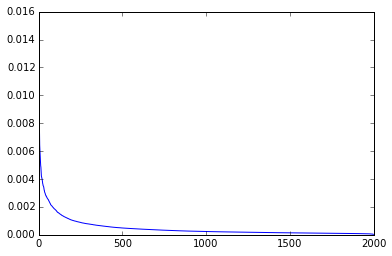

In [16]:
plt.plot(range(0,len(train_set_PCA.explained_variance_ratio_)), train_set_PCA.explained_variance_ratio_)

In [20]:
explained_var_percentages[50]

0.0026484167769864212

In [32]:
red_norm_train_set = cPickle.load(open("./reduced_normalized_train_set.npy",'r'))
#cPickle.dump(red_norm_train_set, open("./reduced_normalized_train_set.npy",'w'))

In [33]:
# retain first 100 PCA components
red_norm_train_set_100 = red_norm_train_set[::,0:100]
cPickle.dump(red_norm_train_set_100 ,open("./red_norm_train_set_100.npy",'w'))

Valid values for metric are:

from scikit-learn: [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]

from scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’]

In [38]:
# We use NearestNeighbors to find users with similar music taste, i.e. construct a similarity matrix

neighbors_unsup = NearestNeighbors(metric = 'correlation', algorithm='brute', n_jobs = 1)
neighbors_unsup.fit(red_norm_train_set_100)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='correlation',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [29]:
test_set = pd.read_csv('test.csv')

In [27]:
# cleanse column names
train_set_unstacked.columns = [ col[1] for col in train_set_unstacked.columns ]

In [35]:
norm_train_set_unstacked = pd.DataFrame(norm_train_set_unstacked, columns = train_set_unstacked.columns)

In [ ]:
preds = []
for x in test_set.iterrows():
    pred_id = x[1][0]
    user_id = x[1][1]
    artist_id = x[1][2]
    user_enum = user_mapping[user_id]
    user_features = red_norm_train_set_100[user_enum]
    neighbors = neighbors_unsup.kneighbors(X=[red_norm_train_set_100[user_enum]], n_neighbors = 25)
    dists = neighbors[0][0][1:]
    k = sum(dists)
    # now find neighbor's ratings and sum, skipping own ratings
    adj = [(float(norm_train_set_unstacked.ix[[nbr]][artist_id])*dists[idx]) / k   for idx, nbr in enumerate(neighbors[1][0][1:])]
    rating = sum(adj) * np.sqrt(stdscaler.var_[user_enum]) + stdscaler.var_[user_enum]
    preds.append(rating)

In [ ]:
%xdel train_set_unstacked

In [ ]:
# example of curse of dimensionality?
closest_5_neighbors_test